<a href="https://colab.research.google.com/github/MdHasanAli35803535/Skin/blob/main/Skin_cancer_diseases_detection_ipnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#LOAD DEPENDENCIES
import os
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import applications
from keras.optimizers import Adam
from keras.models import load_model
from keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.utils import class_weight
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Concatenate, Dropout

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
#LOAD THE DATA
train_data_dir = "/content/drive/MyDrive/skin/data/train"
validation_data_dir = "/content/drive/MyDrive/skin/data/validation"

# THE INPUT LAYER IS THE SAME AS IT WILL BE FUSED AS ONE LATER ON
img_rows, img_cols = 224, 224
input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)
print("Data folders found!")
print("The Input size is set to ", model_input)

Data folders found!
The Input size is set to  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
#DATA GENERATORS

batch_size = 16

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
                                
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
         classes=['0_benign', '1_malignant'])

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
         classes=['0_benign', '1_malignant'])

#CHECK  THE NUMBER OF SAMPLES
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

if nb_train_samples == 0:
    print("NO DATA TRAIN FOUND! Please check your train data path and folders!")
else:
    print("Train samples found!")
    
if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

num_classes= len(train_generator.class_indices)

if nb_train_samples and nb_validation_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Train samples found!
Validation samples found!
Generators are set!
Check if dataset is complete and has no problems before proceeding.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
print(class_weights)

[0.915625   1.10150376]


In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# MobileNetV2-A 

#TRANSFER LEARNING
def MobileNetV2_builder_A(model_input):
    MobileNetV2_builder_A = MobileNetV2(weights='imagenet', include_top=False, input_tensor=model_input)
    
#PARTIAL LAYER FREEZING
    for layer in MobileNetV2_builder_A.layers:
        layer.trainable = False 

#MODEL TRUNCATION
    x = MobileNetV2_builder_A.layers[-1].output
    model = Model(inputs=MobileNetV2_builder_A.input, outputs=x, name='rmstu_mobilenetv2_A')
    return model

#GENERATE THE MODEL
rmstu_mobilenetv2_A = MobileNetV2_builder_A(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
rmstu_mobilenetv2_A.summary()
print("rmstu_mobilenetv2_A successfully built!")

9406464/9406464 [==============================] - 0s 0us/step
PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "rmstu_mobilenetv2_A"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_mirror_mirror (InputLa  [(None, 224, 224, 3  0          []                               
 yer)                           )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1_mirror_mirror[0][0]']  
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1

In [ ]:
# MobileNet-B

#TRANSFER LEARNING
def MobileNetV2_builder_B(model_input):
    MobileNetV2_builder_B = MobileNetV2(weights='imagenet', include_top=False, input_tensor=model_input)
    
#RE-TRAINING ALL LAYERS (RE-NAMING LAYERS TO PREVENT OVERLAPS)
    for layer in MobileNetV2_builder_B.layers:
        layer.trainable = True
        layer._name = layer._name + str("_mirror")

#MODEL TRUNCATION
    x = MobileNetV2_builder_B.layers[-1].output
    model = Model(inputs=MobileNetV2_builder_B.input, outputs=x, name='rmstu_mobilenetv2_B')
    return model

#GENERATE THE MODEL
rmstu_mobilenetv2_B = MobileNetV2_builder_B(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
rmstu_mobilenetv2_B.summary()
print("rmstu_mobilenetv2_B successfully built!")

PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "rmstu_mobilenetv2_B"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_mirror_mirror_mirror (  [(None, 224, 224, 3  0          []                               
 InputLayer)                    )]                                                                
                                                                                                  
 Conv1_mirror (Conv2D)          (None, 112, 112, 32  864         ['input_1_mirror_mirror_mirror[0]
                                )                                [0]']                            
                                                                                                  
 bn_Conv1_mirror (BatchNormaliz  (None, 112, 112, 32  128        ['Conv1_mirror[0][0]']           
 ation)                         )   

In [ ]:
#PREPARE THE CONCATENATION OF THE PRE-TRAINED MODELS
rmstu_mobilenetv2_A = MobileNetV2_builder_A(model_input)
rmstu_mobilenetv2_B = MobileNetV2_builder_B(model_input)

print("rmstu_mobilenetv2_A and rmstu_mobilenetv2_B accomplished Pre-training and ready for concatenation")

rmstu_mobilenetv2_A and rmstu_mobilenetv2_B accomplished Pre-training and ready for concatenation


In [ ]:
#CONCATENATE AS THE MODELS AS A SINGLE PIPELINE

models = [rmstu_mobilenetv2_A, 
          rmstu_mobilenetv2_B]

print("Concatenation success!")
print("rmstu_inceptionresnetv2 ready to connect with its ending layers!")

Concatenation success!
rmstu_inceptionresnetv2 ready to connect with its ending layers!


In [ ]:
#BUILD THE FUSED-DENSENET-TINY

def mobilenetv2(models, model_input):
    outputs = [m.output for m in models]
    y = Add()(outputs)               
    y = GlobalAveragePooling2D(name='GAP-mobilenetv2')(y)
    y = Dense(512, activation='relu', use_bias=True)(y)
    y = Dropout(0.5, name='Dropout-mobilenetv2')(y)
    prediction = Dense(num_classes,activation='softmax', name='Softmax-mobilenetv2')(y)
    model = Model(model_input, prediction, name='mobilenetv2')
    return model

#istantitate the ensemble model and report the summary
mobilenetv2_model = mobilenetv2(models,model_input)

print()
print()
print("PLEASE CHECK THE MODEL UP TO THE END")
print("Fused-DenseNet-Tiny complete and ready for compilation and training!")
print()
print()
print()

mobilenetv2_model.summary()
print("Building of the Fused-DenseNet-Tiny COMPLETE!")



PLEASE CHECK THE MODEL UP TO THE END
Fused-DenseNet-Tiny complete and ready for compilation and training!



Model: "mobilenetv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_mirror_mirror_mirror_m  [(None, 224, 224, 3  0          []                               
 irror (InputLayer)             )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1_mirror_mirror_mirror_mi
                                )                                rror[0][0]']                     
                                                                                                  
 Conv1_mirror (Conv2D)          (None, 112, 112, 32  864         ['input_1_m

In [ ]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
import time

batch_size = 16

epochs = 25

start_time = time.time()

optimizer = Adam(lr=0.0001)

mobilenetv2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.000001)

callbacks = [reduce_lr]

# MODEL TRAINING

history = mobilenetv2_model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  callbacks=callbacks, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)

elapsed_time = time.time() - start_time
train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print()
print()
print(train_time, 'train_time')
print()
print(elapsed_time, 'Seconds')
print()
print()
print("MODEL SERIALIZING WAIT FOR A MOMENT...")
print()

#SAVE AFTER TRAINING COMPLETES

mobilenetv2_model.save('/content/drive/MyDrive/skin/weights.h5')

#SAVE THE HISTORY FOR EVALUATION

from pickle import dump
dump(history, open('/content/drive/MyDrive/skin/history.pkl', 'wb'))

print()
print()
print("The Model weights and history are successfully trained and saved!")

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-17-af681ee42f61>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobilenetv2_model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size,


Epoch 1/25
164/164 [==============================] - 967s 6s/step - loss: 0.5346 - accuracy: 0.7814 - val_loss: 0.6782 - val_accuracy: 0.7591 - lr: 1.0000e-04
Epoch 2/25
164/164 [==============================] - 24s 143ms/step - loss: 0.2611 - accuracy: 0.8848 - val_loss: 0.7477 - val_accuracy: 0.7424 - lr: 1.0000e-04
Epoch 3/25
164/164 [==============================] - 24s 147ms/step - loss: 0.1877 - accuracy: 0.9210 - val_loss: 0.4897 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/25
164/164 [==============================] - 25s 154ms/step - loss: 0.1394 - accuracy: 0.9416 - val_loss: 1.1449 - val_accuracy: 0.7271 - lr: 1.0000e-04
Epoch 5/25
164/164 [==============================] - 24s 145ms/step - loss: 0.0810 - accuracy: 0.9714 - val_loss: 1.5733 - val_accuracy: 0.7058 - lr: 1.0000e-04
Epoch 6/25
164/164 [==============================] - 24s 146ms/step - loss: 0.0749 - accuracy: 0.9706 - val_loss: 0.7831 - val_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 7/25
164/164 [==========



The Model weights and history are successfully trained and saved!


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import PIL
import cv2
import logging
import itertools
import scikitplot 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



from pickle import load
from keras import applications
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from keras.models import Model
from sklearn.metrics import mean_squared_log_error
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121, preprocess_input
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc

In [ ]:
#HYPER-PARAMETERS USED NO NEED TO CHANGE. MAKE SURE IT MATCHES WITH YOUR TRAINED MODEL. 
#THIS IS MAINLY FOR PLOTTING PURPOSES ONLY

batch_size = 16

epochs = 25

print("Batch Size is set to:", batch_size)
print("Epoch is set to:", epochs)
print()
print("Make sure it matches with your trained model before proceeding to prevent problems")

Batch Size is set to: 16
Epoch is set to: 25

Make sure it matches with your trained model before proceeding to prevent problems


In [ ]:
#LOAD THE TRAINED MODEL USING  THE model_trainer.ipynb

history = load(open('/content/drive/MyDrive/skin/history.pkl', 'rb'))
model = load_model('/content/drive/MyDrive/skin/weights.h5')
model._name="mobilenetv2_model"
model.summary()

if len(model.layers) == 312:
    print("MODEL IS READY!")
elif len(model.layers) != 312:
    print("INCORRECT MODEL!")
    
print("mobilenetv2_model MODEL SUCCESSFULLY LOADED!")

Model: "mobilenetv2_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_mirror_mirror_mirror_m  [(None, 224, 224, 3  0          []                               
 irror (InputLayer)             )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1_mirror_mirror_mirror_mi
                                )                                rror[0][0]']                     
                                                                                                  
 Conv1_mirror (Conv2D)          (None, 112, 112, 32  864         ['input_1_mirror_mirror_mirror_mi
                                )                                rror[0][0]']     

In [ ]:
#VISUAL CUSTOMIZER

marker_t = '^'
marker_v = '+'
market_t_loss = 'v'
market_v_loss = 'x'
markersize = 5
fillstyle_t = 'none'
fillstyle_v = 'none'

color_t = 'blue'
color_v = 'orange'

labelsize = 10

color_t_loss = 'green'
color_v_loss = 'red'

border_pad = 0.5
legend_font_size = 9

ls_t = '-' 
ls_v = '--'
lw_t = '1.5'
lw_v = '1.5'

print("You may change the values if needed for the ease of your evaluation")

You may change the values if needed for the ease of your evaluation


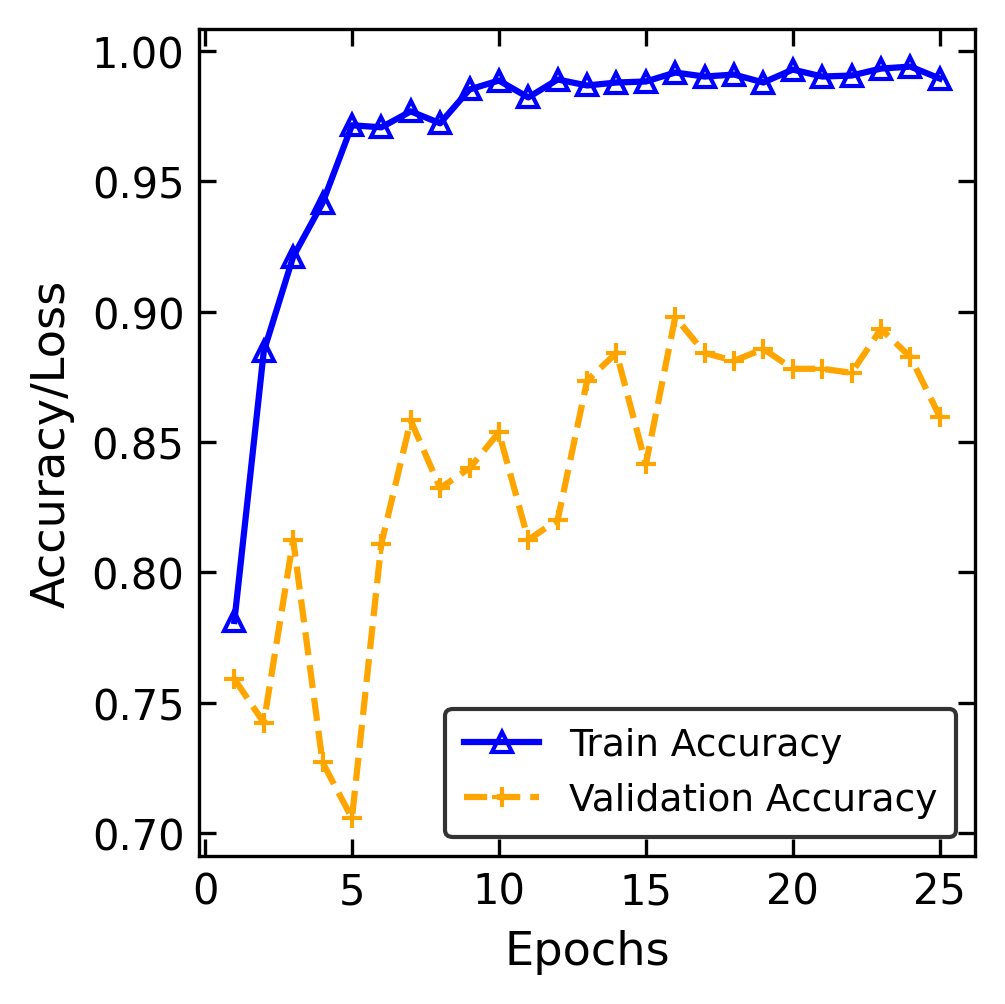

In [ ]:
#PRINTS THE ACCURACY GROWTH

N = epochs
plt.style.use("default")
plt.figure(figsize=(1.15*3,1.15*3), dpi=300, edgecolor='black', facecolor='white', linewidth=0)
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.15)

plt.rc('xtick',labelsize=labelsize, direction="in" ) 
plt.rc('ytick', labelsize=labelsize, direction="in") 
plt.tick_params(length=4, right=True, top=True)

plt.plot(np.arange(1, N+1), history.history["accuracy"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")

plt.xlabel("Epochs", fontsize=3.7*3, color='black')
plt.ylabel("Accuracy/Loss", fontsize=3.7*3, color='black')
plt.legend(loc="lower right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/skin/Figures-2/1-accuracy.jpg", bbox_inches='tight', dpi=600)

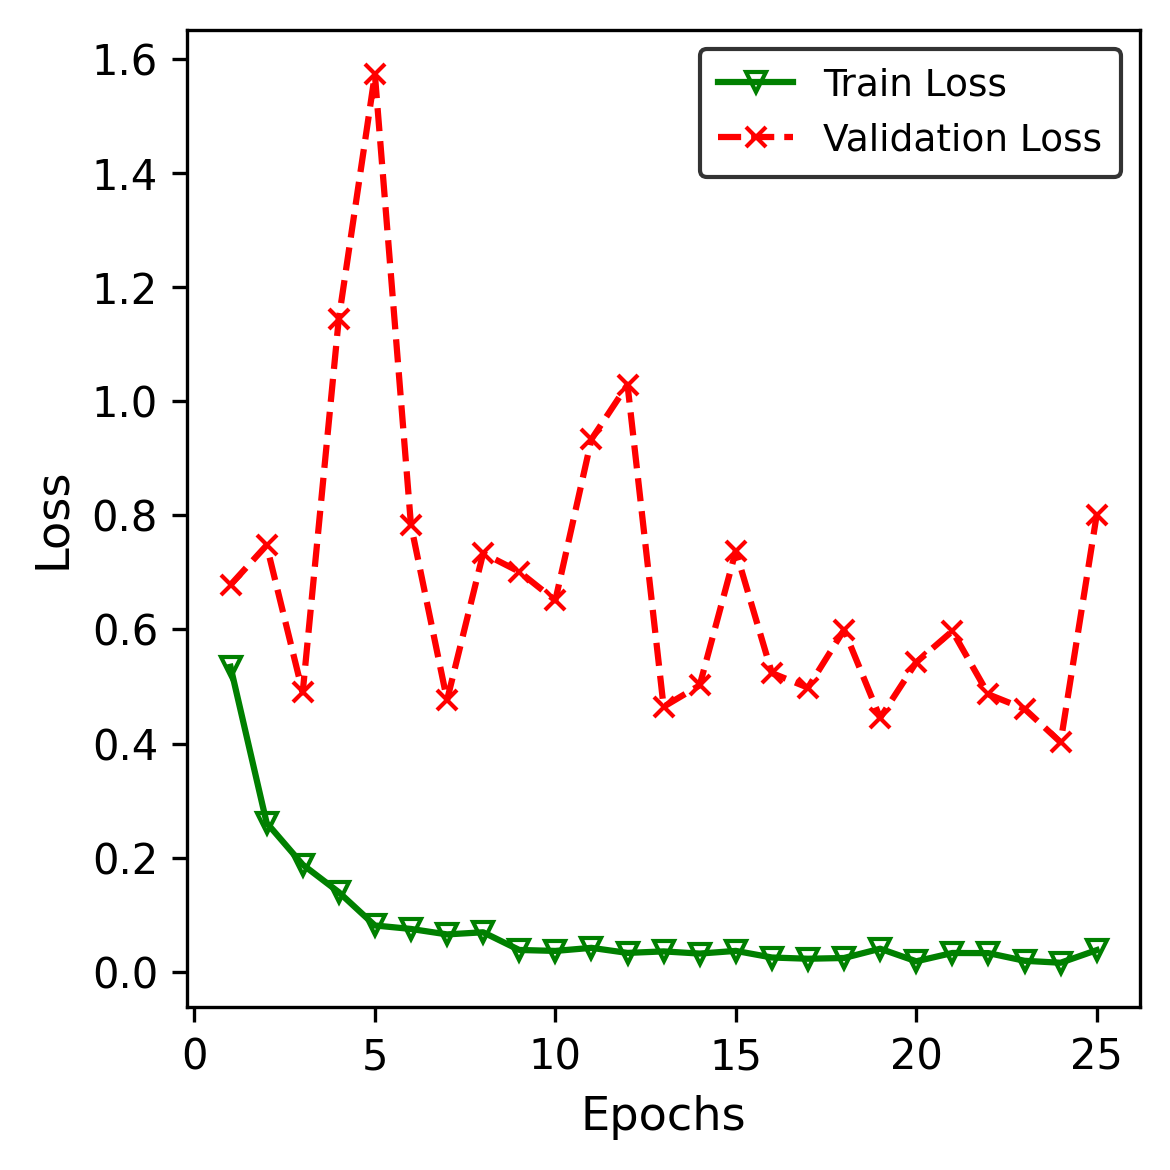

In [ ]:
#PRINTS THE DECREASE OF LOSS

N = epochs
plt.style.use("default")
plt.figure(figsize=(4,4), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Loss")

plt.xlabel("Epochs", fontsize=3.7*3, color='black')
plt.ylabel("Loss", fontsize=3.7*3, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/skin/Figures-2/2-loss.png")

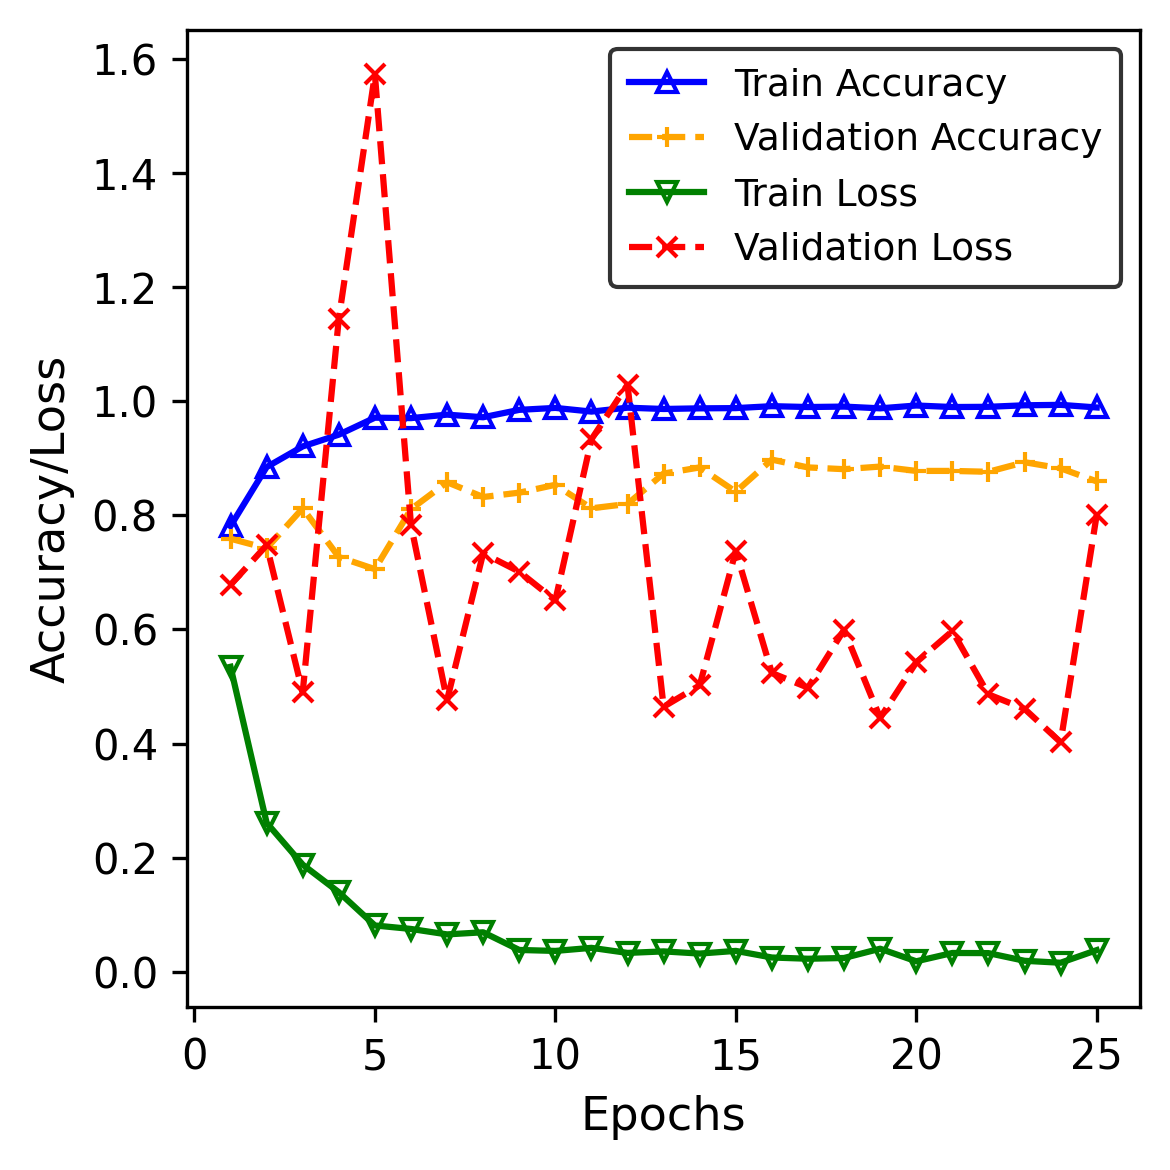

In [ ]:
#PRINTS BOTH ACCURACY AND LOSS IN ONE GRAPH

N = epochs
plt.style.use("default")
plt.figure(figsize=(4,4), dpi=300)
plt.plot(np.arange(1, N+1), history.history["accuracy"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")
plt.plot(np.arange(1, N+1), history.history["loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Loss")

plt.xlabel("Epochs", fontsize=3.7*3, color='black')
plt.ylabel("Accuracy/Loss", fontsize=3.7*3, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/skin/Figures-2/3-convergence.png")

In [ ]:
#EVALUATION FOR THE FUSED-DENSENET-TINY

#evaluate accuracy
y_pred = model.predict_generator(validation_generator,
                                               nb_validation_samples/batch_size, workers=1)
accuracy = accuracy_score(Y_test,y_pred.argmax(axis=-1))
print('The accuracy of the Fused DenseNet-Tiny model is: ', accuracy)

#evaluate mean squared error
mse = mean_squared_error(Y_test,y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Fused DenseNet-Tiny model is: ', mse)

#evaluate mean squared log error
msle = mean_squared_log_error(Y_test,y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Fused DenseNet-Tiny model is: ', msle)

<ipython-input-27-497d8fb1cd25>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(validation_generator,


The accuracy of the Fused DenseNet-Tiny model is:  0.8606060606060606
The Mean Squared Error of the Fused DenseNet-Tiny model is:  0.1393939393939394
The Mean Squared Log Error of the Fused DenseNet-Tiny model is:  0.06697223830374928


              precision    recall  f1-score   support

      benign     0.9497    0.7861    0.8602       360
   malignant     0.7873    0.9500    0.8610       300

    accuracy                         0.8606       660
   macro avg     0.8685    0.8681    0.8606       660
weighted avg     0.8759    0.8606    0.8606       660

Confusion matrix, without normalization
[[283  77]
 [ 15 285]]


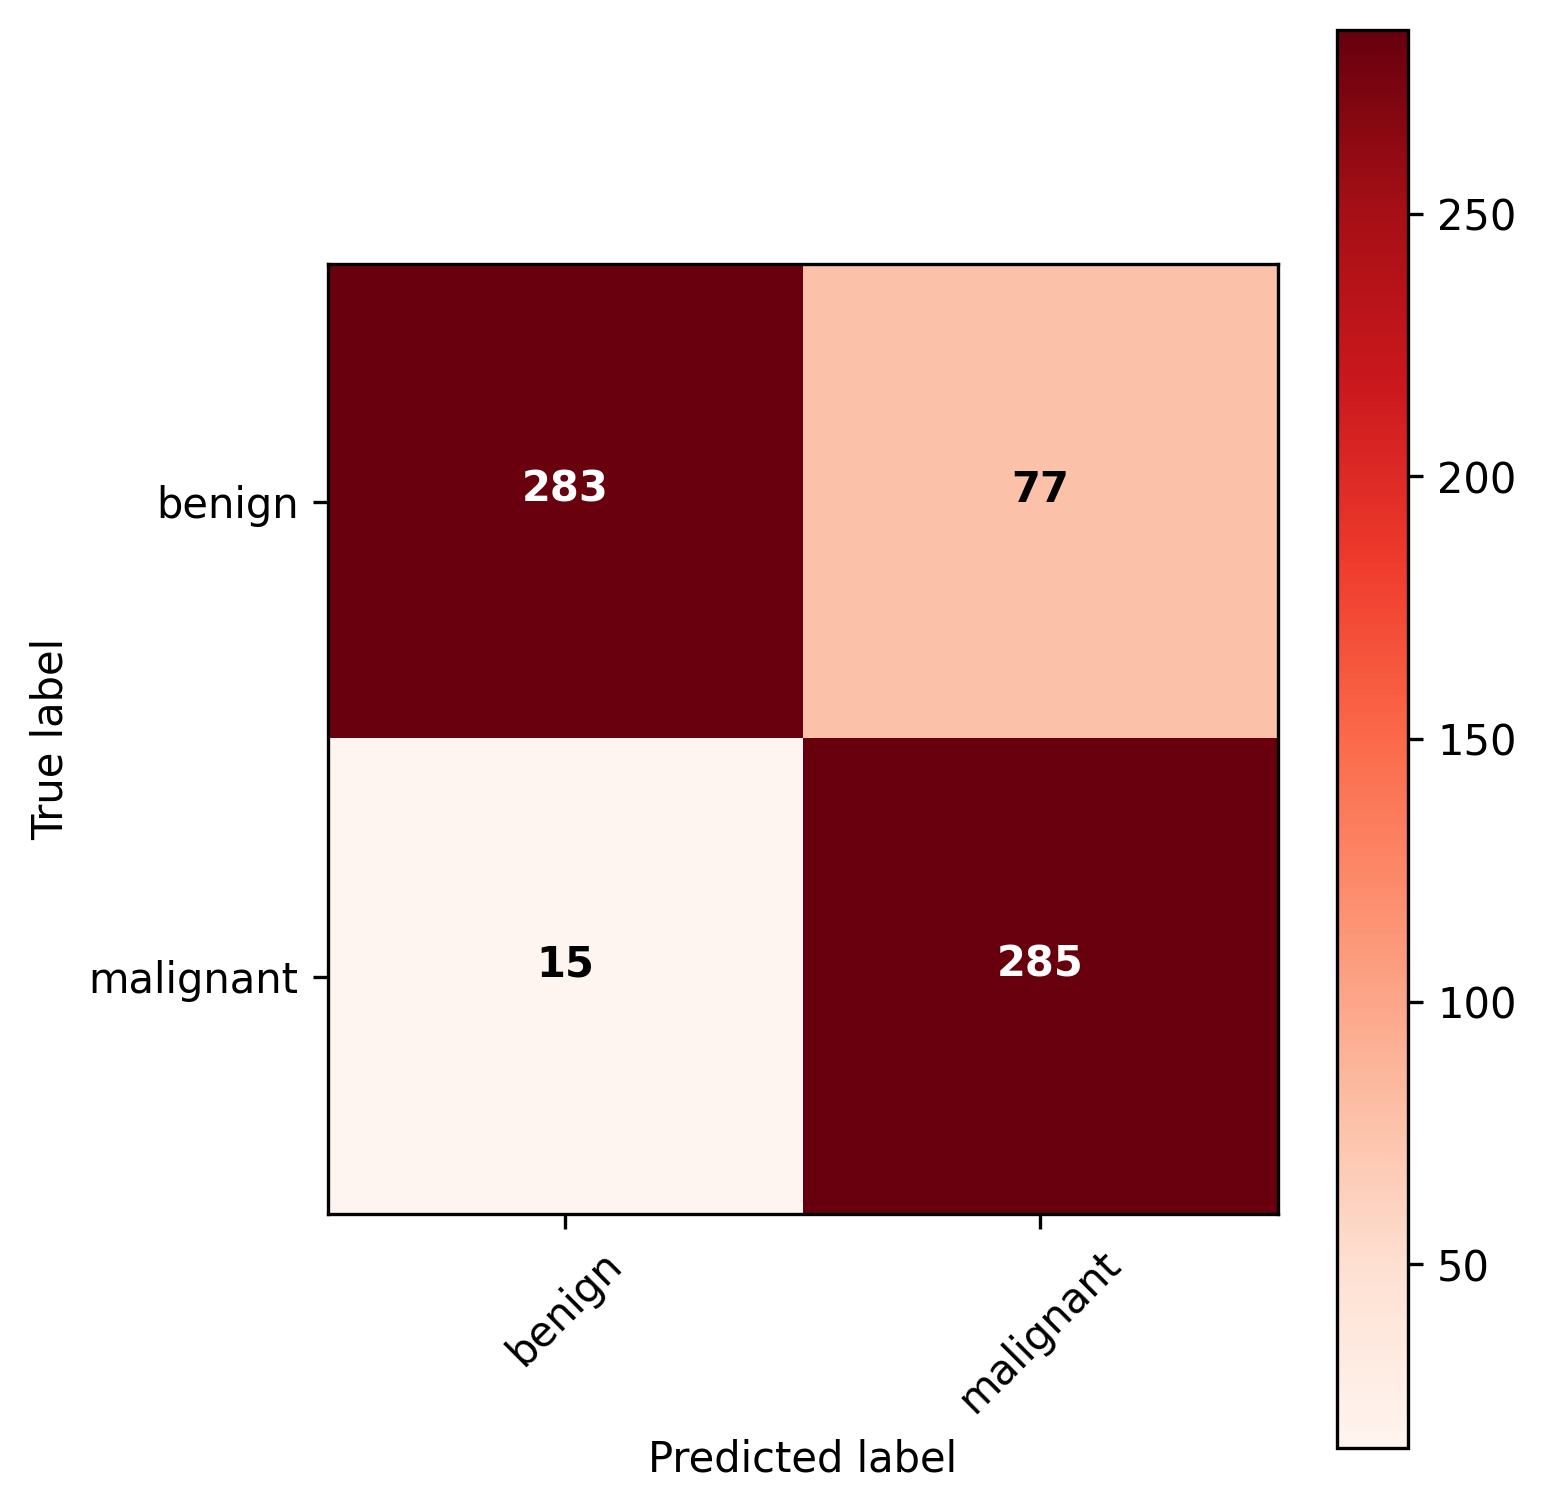

In [ ]:
# CONFUSION MATRIX

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], weight='bold',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['benign', 'malignant']
print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25,5.25), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/skin/Figures-2/confusion_matrix.png", dpi=600)
plt.show()

              precision    recall  f1-score   support

      benign     0.9497    0.7861    0.8602       360
   malignant     0.7873    0.9500    0.8610       300

    accuracy                         0.8606       660
   macro avg     0.8685    0.8681    0.8606       660
weighted avg     0.8759    0.8606    0.8606       660

Normalized confusion matrix
[[0.7861 0.2139]
 [0.05   0.95  ]]


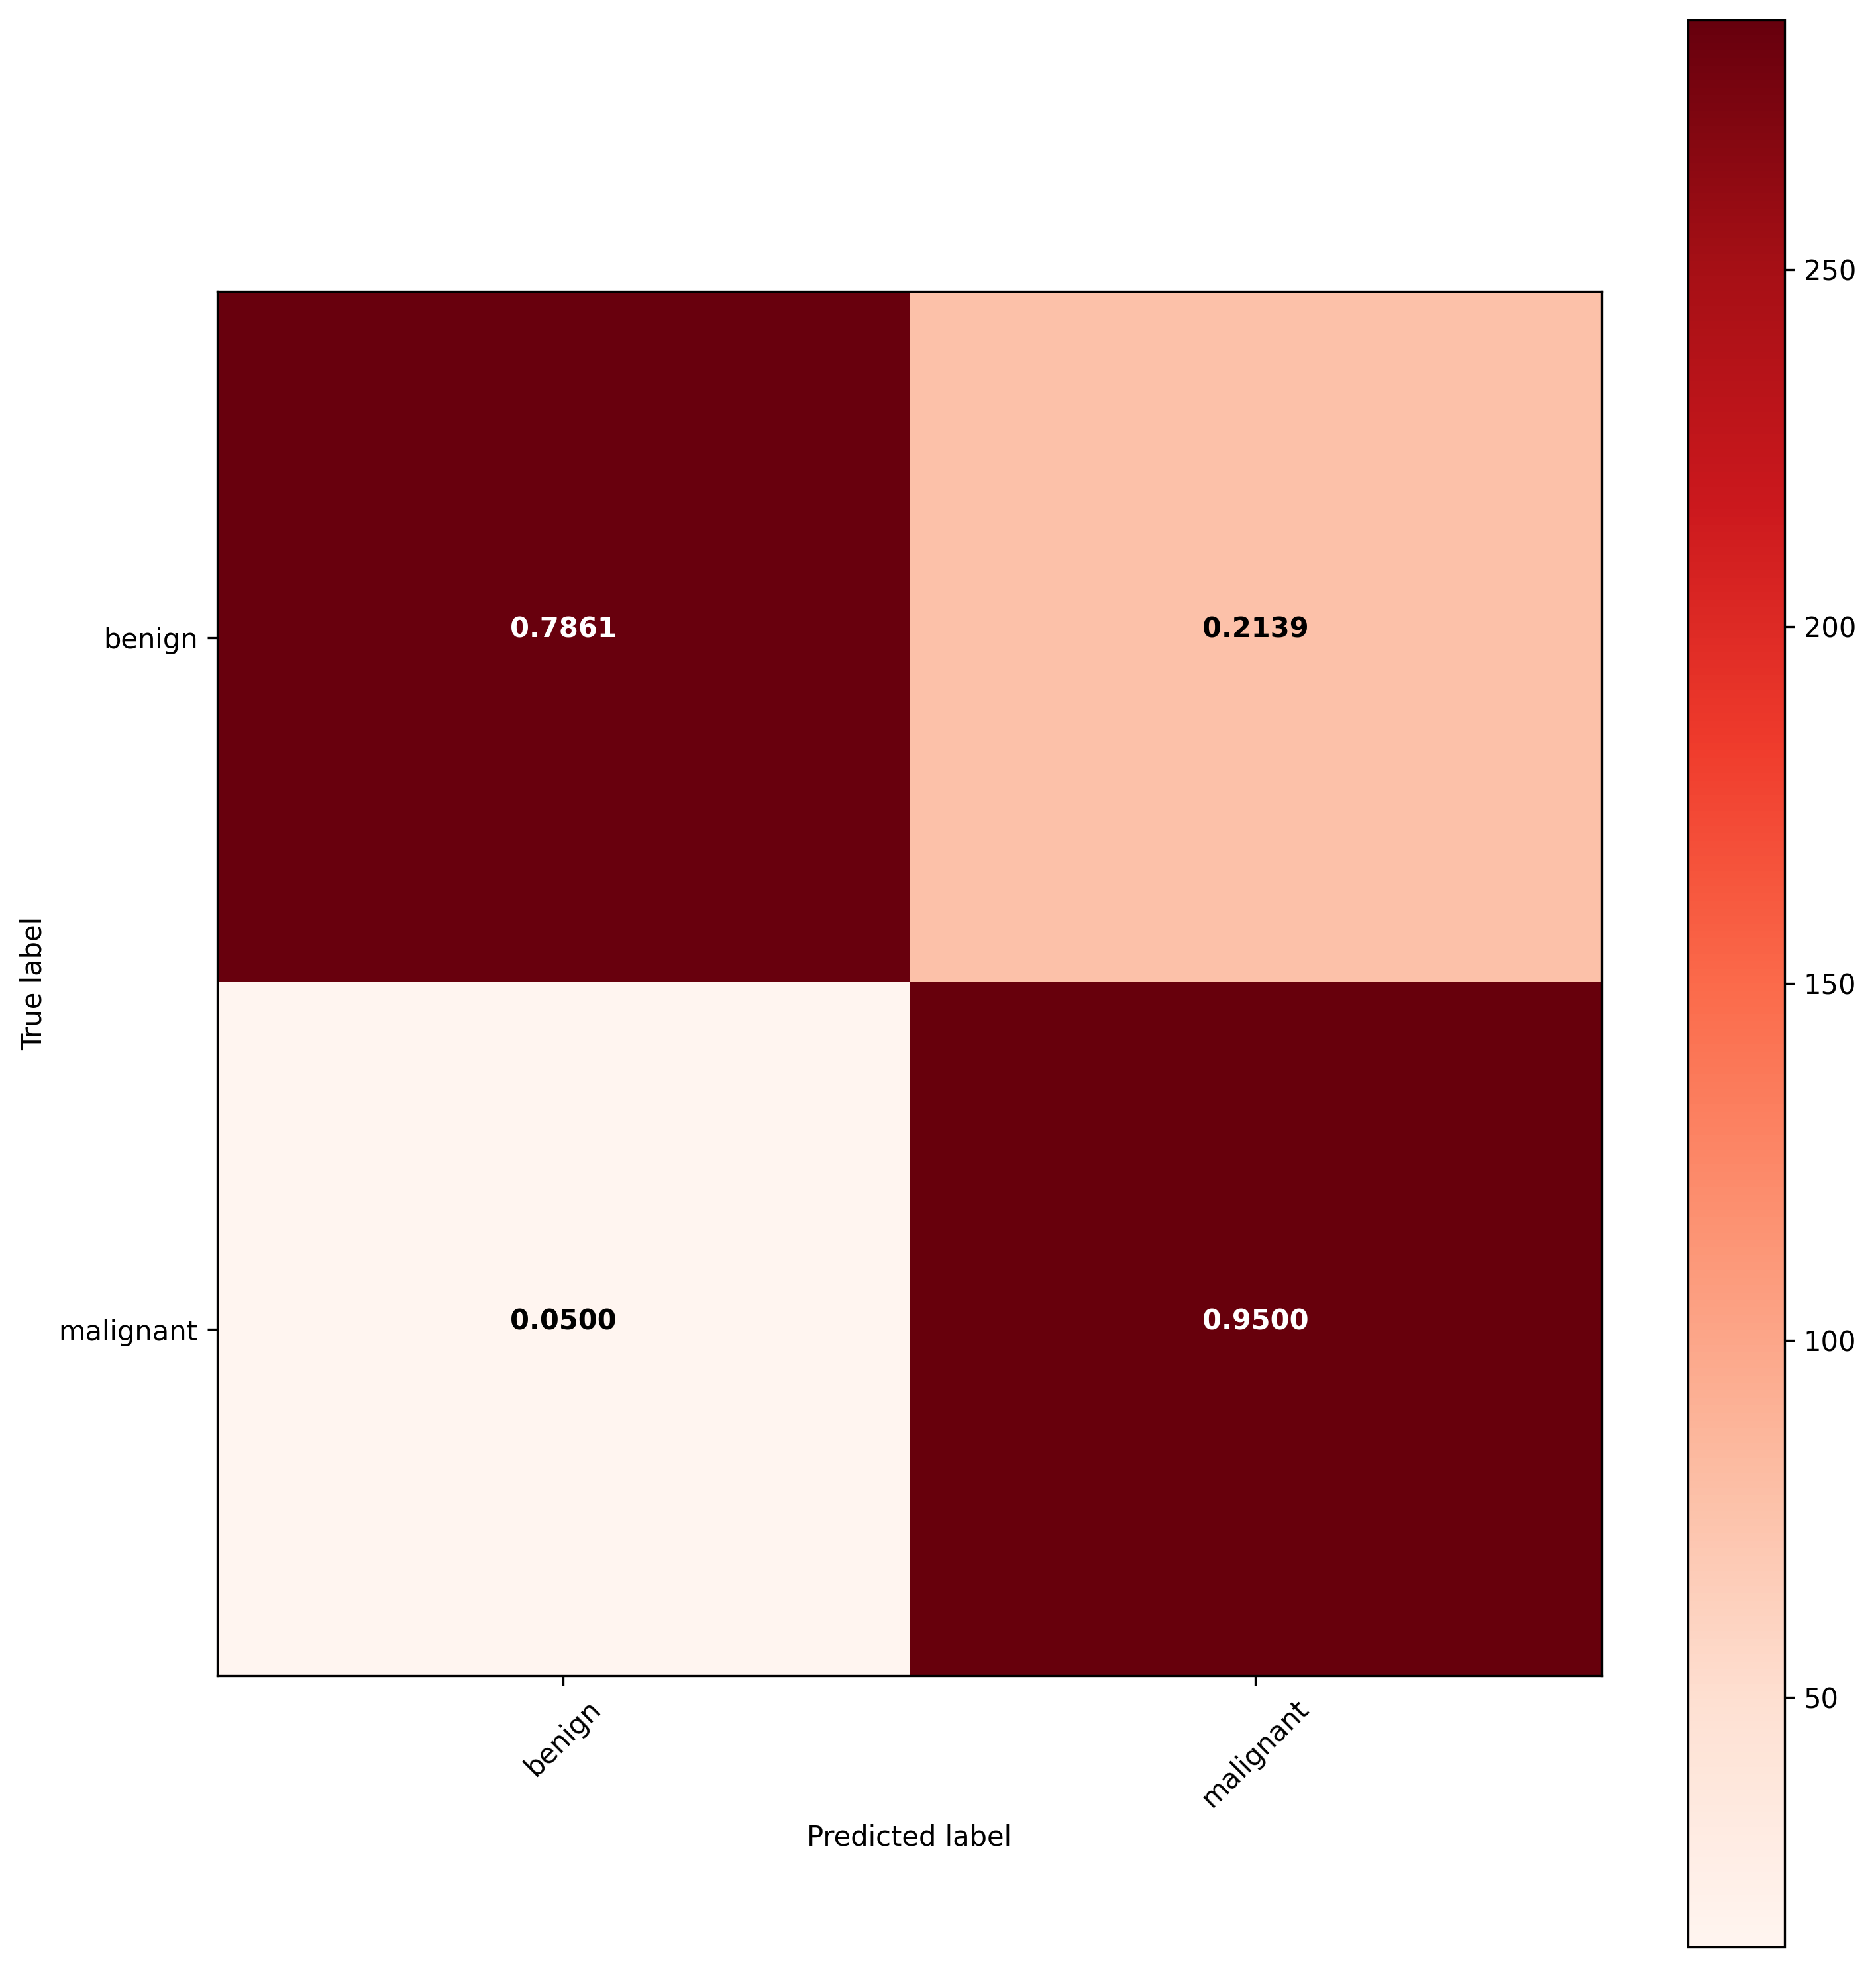

In [ ]:
# custom function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title='',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.4f'), weight='bold',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['benign', 'malignant']
print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/skin/Figures-2/confusion_matrix-normalized.png", dpi=600)
plt.show()

42/42 [==============================] - 4s 105ms/step


<Figure size 2400x2400 with 0 Axes>

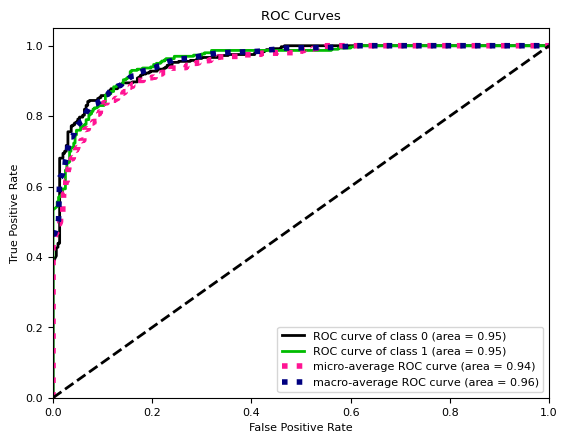

In [ ]:
#PRINT THE ROC CURVE

plt.figure(figsize=(8,8), dpi=300)
plt.rcParams.update({'font.size': 8})
y_probas = model.predict(validation_generator)
scikitplot.metrics.plot_roc(Y_test, y_pred)
plt.savefig("/content/drive/MyDrive/skin/Figures-2/ROC_curve.png", dpi=600)
plt.show()

42/42 [==============================] - 3s 71ms/step


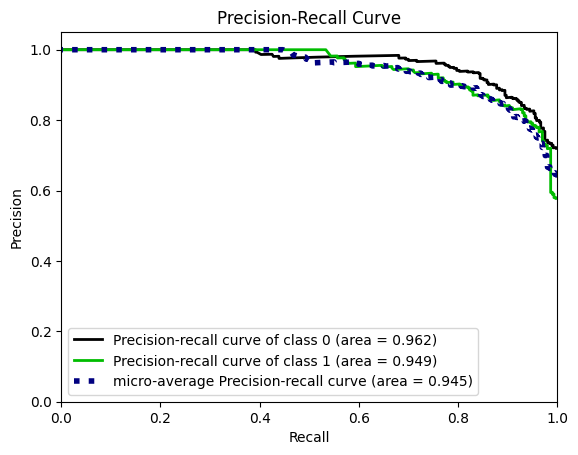

<Figure size 6000x6000 with 0 Axes>

In [ ]:
#PRINT THE P-R CURVE

plt.rcParams.update({'font.size': 10})
y_probas = model.predict(validation_generator)
scikitplot.metrics.plot_precision_recall(Y_test, y_pred)
plt.savefig("/content/drive/MyDrive/skin/Figures-2/PR_curve.png", dpi=600)
plt.figure(figsize=(20, 20), dpi=300) 
plt.show()

In [ ]:
#LOAD THE DEPENDENCIES
import os
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input

#PREVENTS UNWANTED PROMPTS
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
#LOAD THE TRAINED MODEL

model = load_model("/content/drive/MyDrive/skin/weights.h5") 
print("mobilenetv2_model!")
print("The model consist of ", len(model.layers), "layers")

mobilenetv2_model!
The model consist of  312 layers


In [ ]:
#CHOOSE ANY IMAGE FROM YOUR TEST DATASET
img_path = '/content/drive/MyDrive/skin/data/test/59.jpg' #YOU CAN CHANGE THIS

In [ ]:
from tensorflow.keras.preprocessing import image

Image successfully loaded for diagnosis


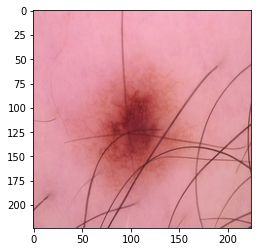

In [ ]:
#PREPARE THE DATA INPUT

img_width, img_height = 224, 224

img1 = image.load_img(img_path)
plt.imshow(img1);

img = image.load_img(img_path, target_size=(img_width, img_height))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print("Image successfully loaded for diagnosis")

In [ ]:
#PREPARE THE FUSED-DENSENET-TINY FOR TESTING

def fused_densenet_tiny(x, model):
    
    conf = model.predict(x)
    conf_score = max(100 * conf[0])
    
    predictions = model.predict(x).argmax()   
    plt.imshow(img)
    
    if predictions == 0:
        print("The image was diagnosed to Benign .")
        print("The confidence of the model is roughly", conf_score,"%.")
        print()
       

        
    else:
        print("The image was diagnosed to Malignant.")
        print("The confidence of the model is", conf_score,"%.")
        print()
        

1/1 [==============================] - 0s 26ms/step
The image was diagnosed to Benign .
The confidence of the model is roughly 100.0 %.



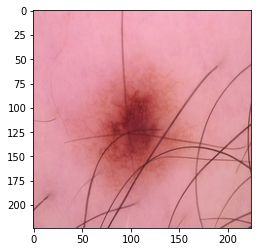

In [ ]:
#DIAGNOSE THE INPUT IMAGE WITH THE FUSED-DENSENET-TINY

fused_densenet_tiny(x, model)